In [1]:
# Global imports and settings
%matplotlib inline
from preamble import *
HTML('''<style>html, body{overflow-y: visible !important} .CodeMirror{min-width:105% !important;} .rise-enabled .CodeMirror, .rise-enabled .output_subarea{font-size:140%; line-height:1.2; overflow: visible;} .output_subarea pre{width:110%} .rendered_html table, .rendered_html td, .rendered_html th {font-size: 200%;}</style>''')# For slides
interactive = False # Set to True for interactive plots 
if interactive:
    plt.rcParams['figure.dpi'] = 150
else:
    plt.rcParams['figure.dpi'] = 100

# Recap: k-Nearest Neighbor

* Building the model consists only of storing the training dataset. 
* To make a prediction, the algorithm finds the _k_ closest data points in the training dataset
    * Classification: predict the most frequent class of the k neighbors
    * Regression: predict the average of the values of the k neighbors
    * Both can be weighted by the distance to each neighbor
* Main hyper-parameters:
    * Number of neighbors (k). Acts as a regularizer.
    * Choice of distance function (e.g. Euclidean)
    * Weighting scheme (uniform, distance,...)
* Model:
    - Representation: Store training examples (e.g. in KD-tree)
    - Typical loss functions:
        * Classification: Accuracy (Zero-One Loss)
        * Regression: Root mean squared error
    - Optimization: None (no model parameters to tune)

## k-Nearest Neighbor Classification
k=1: look at nearest neighbor only: likely to overfit  
k>1: do a vote and return the majority (or a confidence value for each class)

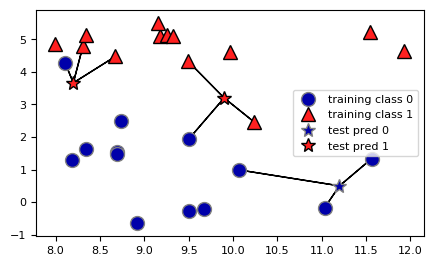

In [2]:
mglearn.plots.plot_knn_classification(n_neighbors=3)

#### Analysis
We can plot the prediction for each possible input to see the _decision boundary_

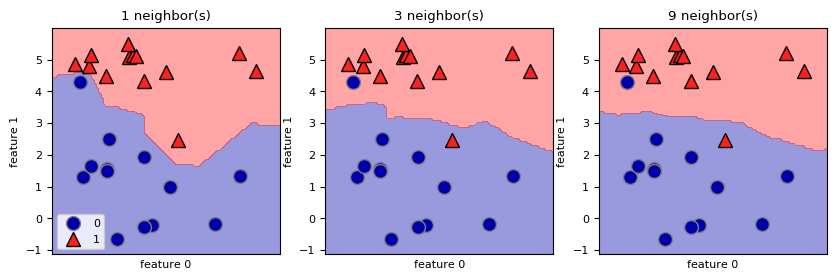

In [3]:
from sklearn.neighbors import KNeighborsClassifier
X, y = mglearn.datasets.make_forge()
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

for n_neighbors, ax in zip([1, 3, 9], axes):
    clf = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X, y)
    mglearn.plots.plot_2d_separator(clf, X, fill=True, eps=0.5, ax=ax, alpha=.4)
    mglearn.discrete_scatter(X[:, 0], X[:, 1], y, ax=ax)
    ax.set_title("{} neighbor(s)".format(n_neighbors))
    ax.set_xlabel("feature 0")
    ax.set_ylabel("feature 1")
_ = axes[0].legend(loc=3)

Using few neighbors corresponds to high model complexity (left), and using many neighbors corresponds to low model complexity and smoother decision boundary (right).

### Nearest Shrunken Centroid
* Nearest Centroid: Represents each class by the centroid of its members.
    * Parameteric model (while kNN is non-parametric)
* Regularization is possible with the `shrink_threshold` parameter
    * Shrinks (scales) each feature value by within-class variance of that feature
    * Soft thresholding: if feature value falls below threshold, it is set to 0
    * Effectively removes (noisy) features

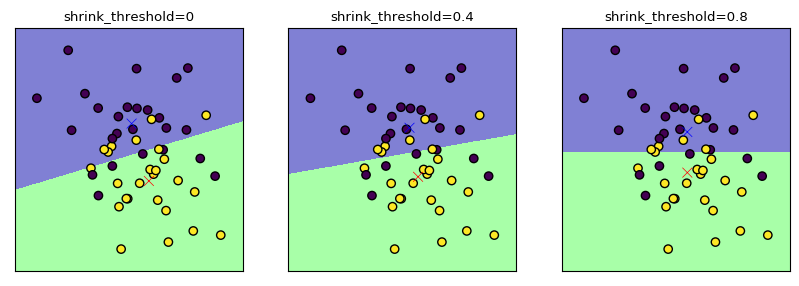

In [10]:
from sklearn.neighbors import NearestCentroid
from sklearn.datasets import make_blobs
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
thresholds = [0, 0.4, .8]
X, y = make_blobs(centers=2, cluster_std=2, random_state=0, n_samples=50)

for threshold, ax in zip(thresholds, axes):
    ax.set_title(f"shrink_threshold={threshold}")
    nc = NearestCentroid(shrink_threshold=threshold)
    nc.fit(X, y)
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k')
    mglearn.tools.plot_2d_classification(nc, X, alpha=.5, ax=ax)
    ax.scatter(nc.centroids_[:, 0], nc.centroids_[:, 1], c=['b', 'r'], s=50, marker='x')
    ax.set_aspect("equal")

Note: Nearest Centroid suffers when the data is not 'convex'

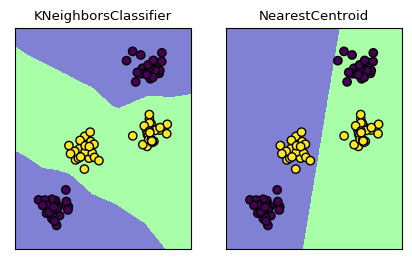

In [11]:
X, y = make_blobs(centers=4, random_state=8)
y = y % 2

knn = KNeighborsClassifier(n_neighbors=1).fit(X, y)
nc = NearestCentroid().fit(X, y)

plt.figure
fig, axes = plt.subplots(1, 2)
for est, ax in [(knn, axes[0]), (nc, axes[1])]:
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k')
    
    ax.set_title(est.__class__.__name__)
    mglearn.tools.plot_2d_classification(est, X, alpha=.5, ax=ax)
    ax.set_aspect("equal")

#### Scalability
With n = nr examples and p = nr features
* Nearest shrunken threshold
    * Fit: $O(n * p)$
    * Memory: $O(nrclasses * p)$
    * Predict: $O(nrclasses * p)$
* Nearest neighbors (naive)
    * Fit: $0$
    * Memory: $O(n * p)$
    * Predict: $O(n * p)$
* Nearest neighbors (with KD trees)
    * Fit: $O(p * n log n)$
    * Memory: $O(n * p)$
    * Predict: $O(k * log n)$


## k-Neighbors Regression
k=1: return the target value of the nearest neighbor (overfits easily)  
k>1: return the _mean_ of the target values of the _k_ nearest neighbors

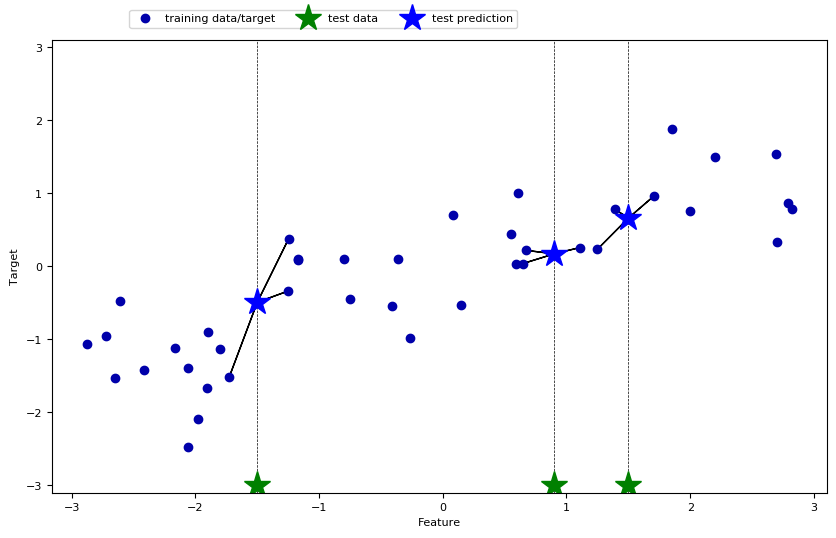

In [12]:
mglearn.plots.plot_knn_regression(n_neighbors=3)

#### Analysis
We can again output the predictions for each possible input, for different values of _k_.

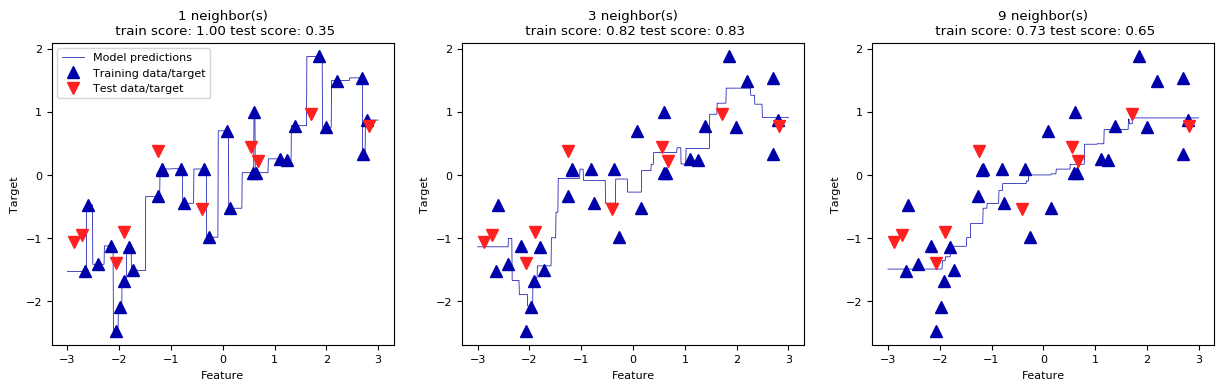

In [14]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split

# split the wave dataset into a training and a test set
X, y = mglearn.datasets.make_wave(n_samples=40)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
# create 1000 data points, evenly spaced between -3 and 3
line = np.linspace(-3, 3, 1000).reshape(-1, 1)
for n_neighbors, ax in zip([1, 3, 9], axes):
    # make predictions using 1, 3 or 9 neighbors
    reg = KNeighborsRegressor(n_neighbors=n_neighbors)
    reg.fit(X_train, y_train)
    ax.plot(line, reg.predict(line))
    ax.plot(X_train, y_train, '^', c=mglearn.cm2(0), markersize=8)
    ax.plot(X_test, y_test, 'v', c=mglearn.cm2(1), markersize=8)

    ax.set_title(
        "{} neighbor(s)\n train score: {:.2f} test score: {:.2f}".format(
            n_neighbors, reg.score(X_train, y_train),
            reg.score(X_test, y_test)))
    ax.set_xlabel("Feature")
    ax.set_ylabel("Target")
_ = axes[0].legend(["Model predictions", "Training data/target",
                "Test data/target"], loc="best")

We see that again, a small _k_ leads to an overly complex (overfitting) model, while a larger _k_ yields a smoother fit.

## kNN: Strengths, weaknesses and parameters
* Easy to understand, works well in many settings
* Training is very fast, predicting is slow for large datasets
* Bad at high-dimensional and sparse data (curse of dimensionality)
* Nearest centroid is a useful parametric alternative, but only if data is (near) linearly separable.